In [ ]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import matplotlib.pyplot as plt

import torch
import torchvision
from torch.backends import cudnn
import torch.optim as optim
import numpy as np
import time
#from blitz.modules import BayesianLinear
#from blitz.utils import variational_estimator
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate
from scipy.stats import entropy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

%pylab inline

In [ ]:
#read the file
df = pd.read_csv('Data Extraction/KNCUSDT-1h-binance.csv')
df['Date'] = df['timestamp']

In [ ]:
#
newdf = df[['Date', 'open','high','low','close']]
data = newdf.sort_index(ascending=True, axis=0)
data

In [ ]:
data['close20'] = data['close'].rolling(window =20).mean()
data['close10'] = data['close'].rolling(window =10).mean()
data['close100'] = data['close'].rolling(window =100).mean()
data['close50'] = data['close'].rolling(window =50).mean()
data['close5'] = data['close'].rolling(window =5).mean()
data['close250'] = data['close'].rolling(window =250).mean()


In [ ]:
data['closeewm30'] = data['close'].ewm(1/30).mean()
data['closeewm50'] = data['close'].ewm(1/50).mean()
data['closeewm100'] = data['close'].ewm(1/100).mean()
data['closeewm200'] = data['close'].ewm(1/200).mean()
data['closeewm250'] = data['close'].ewm(1/250).mean()

In [ ]:
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return slope

In [ ]:
momentums = data.copy(deep=True)
data['closemomentum50'] = data['close'].rolling(50).apply(momentum, raw=False)
data['closemomentum100'] = data['close'].rolling(100).apply(momentum, raw=False)
data['closemomentum250'] = data['close'].rolling(250).apply(momentum, raw=False)

In [ ]:
data['X'] = (data['low']+data['close']+data['high'])/3

In [ ]:
data['X50'] = data['X']-data['close50']
data['AX50'] = data['X50'].rolling(50).mean()
data['CCI50'] = data['X50']/data['AX50']

data['X100'] = data['X']-data['close100']
data['AX100'] = data['X100'].rolling(100).mean()
data['CCI100'] = data['X100']/data['AX100']

data['X250'] = data['X']-data['close250']
data['AX250'] = data['X250'].rolling(250).mean()
data['CCI250'] = data['X250']/data['AX250']

In [ ]:
data['EMAF30100'] = data['closeewm30']-data['closeewm100']
data['EMAF50200'] = data['closeewm50']-data['closeewm200']
data['EMAF50250'] = data['closeewm50']-data['closeewm250']

In [ ]:
data['diffclose'] = data['close'].diff()
data['increase'] = (data['diffclose']<0)*1

In [ ]:
data['Dt'] = data['diffclose']* data['increase']
data['Ut'] = data['diffclose']*(1-data['increase'])
data['Ut50'] = data['Ut'].rolling(50).mean()
data['Ut100'] = data['Ut'].rolling(100).mean()
data['Ut250'] = data['Ut'].rolling(250).mean()
data['Dt50'] = data['Dt'].rolling(50).mean()
data['Dt100'] = data['Dt'].rolling(100).mean()
data['Dt250'] = data['Dt'].rolling(250).mean()

In [ ]:
# Drop the data with NA and split the train and valid set

data = data.drop('Date', axis=1)
train = data[498:10000]
valid = data[10000:]['close']
x_train, y_train = [], []
for i in range(10,len(train)):
    x_train.append(train[i-10:i])
    y_train.append(train['close'][498+i])

In [ ]:
inputs = data[len(data) - len(valid) - 10:]
#inputs = inputs.reshape(-1,1)
X_test = []
for i in range(10,inputs.shape[0]):
    X_test.append(inputs[i-10:i])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1]*41))
valid = valid.reset_index()['close']


In [ ]:
# Data Processing
x_train, y_train = np.array(x_train).astype('float32'), np.array(y_train).astype('float32')
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*41))

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
reglr = LinearRegression().fit(x_train, y_train)
reglr.score(x_train, y_train)

In [ ]:
lrp = reglr.predict(X_test)
reglr.score(X_test,valid)

In [ ]:
plt.figure(figsize=(12, 7.5))
plt.plot(lrp,label = 'OLS')
plt.plot(valid,label = 'Actual')
plt.legend(fontsize = 15)
plt.ylabel('KNC price (USD)',fontsize=15)
plt.xlabel('Hour',fontsize=15)
plt.title('KNC price prediction via OLS regression',fontsize=17)
plt.show()
plt.savefig("KNC_price_prediction_via_OLS_regression.jped")


In [ ]:
def backtesting(lrp,valid):
    dff = pd.DataFrame(lrp)  
    dff['predict'] = lrp
    dff['valid'] = valid
    valid = valid.reset_index()['close']
    Has_KNC = False
    pnl = []
    pnl.append(1000)
    money = 1000
    for k in range(1,len(dff)):
        if dff.iloc[k]['predict'] > dff.iloc[k-1]['valid'] and not Has_KNC:
            share = money/dff.iloc[k-1]['valid']
            Has_KNC = True

        if dff.iloc[k]['predict'] < dff.iloc[k-1]['valid'] and Has_KNC:
            money = share* dff.iloc[k-1]['valid']
            Has_KNC = False
        if Has_KNC:
            pnl.append(share * dff.iloc[k-1]['valid'])
        else:
            pnl.append(money)
    return pnl


In [ ]:
pnl_lr = backtesting(lrp,valid)

In [ ]:
original = valid*1000/valid[0]

plt.figure(figsize=(12, 7.5))
plt.plot(original,label='baseline')
plt.plot(pnl_lr,label = 'Our Strategy')
plt.legend(fontsize = 25)
plt.ylabel('PnL (USD)',fontsize=20)
plt.xlabel('Hour',fontsize=20)
plt.title('The evolution of PNL for strategy compared with baseline',fontsize=20)
plt.show()








In [ ]:
from sklearn import linear_model
reglasso = linear_model.Lasso(alpha=0.05)
reglasso.fit(x_train,y_train)
reglasso.score(x_train,y_train)

In [ ]:
lassop = reglasso.predict(X_test)

In [ ]:
plt.figure(figsize=(12, 7.5))
plt.plot(lassop,label = 'predict')
plt.plot(valid,label = 'Ground Truth')
plt.legend()

In [ ]:
pnl_lasso = backtesting(lassop,valid)

In [ ]:
from sklearn.linear_model import Ridge
regridge = Ridge(alpha=0.05)
regridge.fit(x_train,y_train)
regridge.score(x_train,y_train)

In [ ]:
ridgep = regridge.predict(X_test)
pnl_ridge = backtesting(ridgep,valid)

In [ ]:
from sklearn.svm import SVR
regsvm = SVR(C=10, epsilon=0.1)
regsvm.fit(x_train,y_train)
regsvm.score(x_train,y_train)

In [ ]:
regsvm.score(X_test,valid)

In [39]:
svmp = regsvm.predict(X_test)
pnl_svm = backtesting(svmp,valid)

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


regr = RandomForestRegressor(max_depth=10,bootstrap=False, criterion='mae',n_estimators=300,min_samples_split=2, min_samples_leaf=1,random_state = 4)
regr.fit(x_train, y_train)
regr.score(x_train,y_train)

KeyboardInterrupt: 

In [41]:
regr.score(X_test,valid)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [42]:
regrf = regr.predict(X_test)
pnl_rf = backtesting(regrf,valid)

In [43]:
pnl_rf[-1]

1000

In [44]:
dff = pd.DataFrame(predict)  
dff['predict'] = predict
dff['valid'] = valid
valid = valid.reset_index()['close']

NameError: name 'predict' is not defined

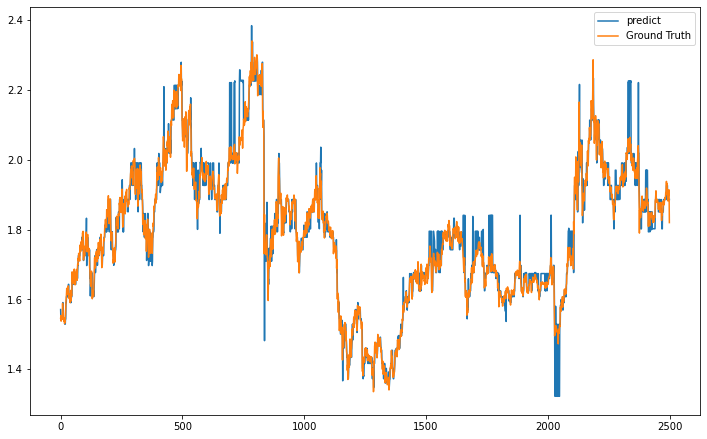

In [325]:
plt.figure(figsize=(12, 7.5))
plt.plot(predict,label = 'predict')
plt.plot(valid,label = 'Ground Truth')
plt.legend()

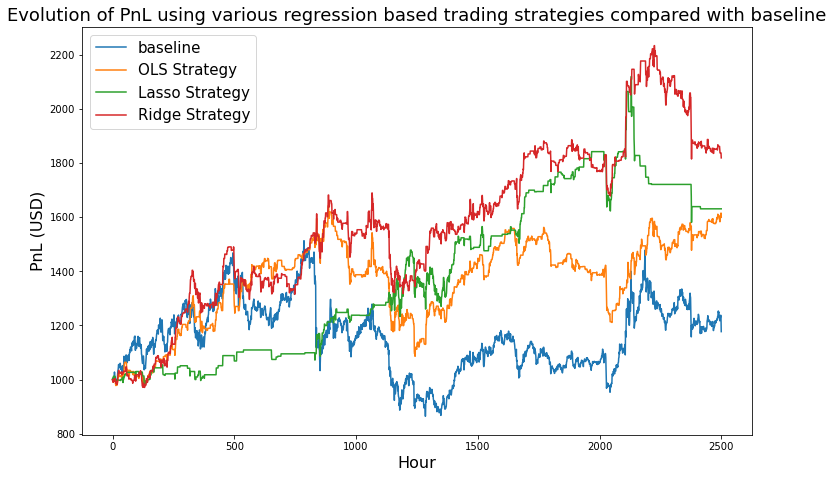

<Figure size 432x288 with 0 Axes>

In [50]:
original = valid*1000/valid[0]

plt.figure(figsize=(12, 7.5))
plt.plot(original,label='baseline')
plt.plot(pnl_lr,label = 'OLS Strategy')
plt.plot(pnl_lasso,label = 'Lasso Strategy')
plt.plot(pnl_ridge,label = 'Ridge Strategy')
plt.legend(fontsize = 15)
plt.ylabel('PnL (USD)',fontsize=16)
plt.xlabel('Hour',fontsize=16)
plt.title('Evolution of PnL using various regression based trading strategies compared with baseline',fontsize=18)
plt.show()
plt.savefig("PnL_regress_various.png")



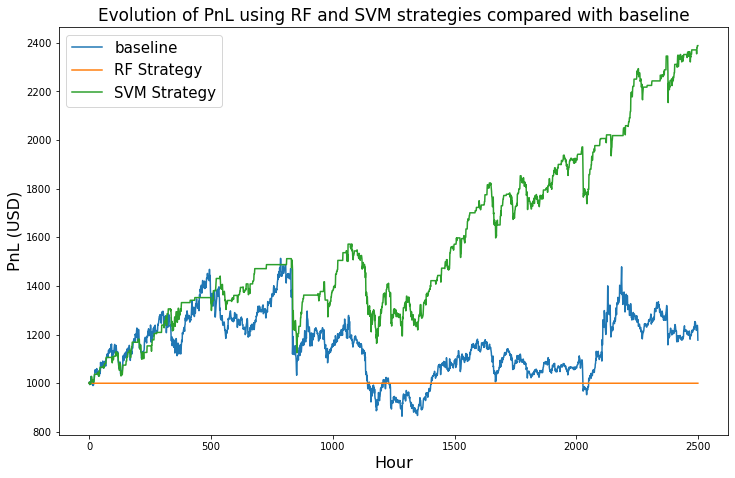

<Figure size 432x288 with 0 Axes>

In [46]:
original = valid*1000/valid[0]

plt.figure(figsize=(12, 7.5))
plt.plot(original,label='baseline')
plt.plot(pnl_rf,label = 'RF Strategy')
plt.plot(pnl_svm,label = 'SVM Strategy')
plt.legend(fontsize = 15)
plt.ylabel('PnL (USD)',fontsize=16)
plt.xlabel('Hour',fontsize=16)
plt.title('Evolution of PnL using RF and SVM strategies compared with baseline',fontsize=17)
plt.show()
plt.savefig("PnL_RF_SVM.png")



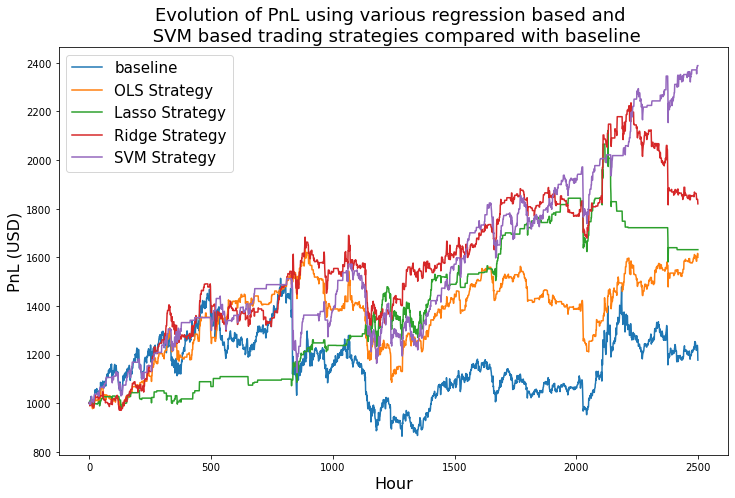

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(12, 7.5))
plt.plot(original,label='baseline')
plt.plot(pnl_lr,label = 'OLS Strategy')
plt.plot(pnl_lasso,label = 'Lasso Strategy')
plt.plot(pnl_ridge,label = 'Ridge Strategy')
plt.plot(pnl_svm, label = "SVM Strategy")
plt.legend(fontsize = 15)
plt.ylabel('PnL (USD)',fontsize=16)
plt.xlabel('Hour',fontsize=16)
plt.title('Evolution of PnL using various regression based and \n SVM based trading strategies compared with baseline',fontsize=18)
plt.show()
plt.savefig("PnL_regress_various_SVM.png")

In [17]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)

In [123]:
@variational_estimator
class BayesianMLP(nn.Module):
    def __init__(self, input_dim, num_classes,p=0.5):
        super().__init__()
        self.drop = nn.Dropout(p=p)
        self.bfc1 = nn.Linear(input_dim, 1024)
        self.bfc2 = nn.Linear(1024, 128)
        self.bfc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Flatten image
        #x = x.view(-1,28*28)
        x = self.bfc1(x)
        x = self.drop(x)
        x = F.relu(x)
        x = self.bfc2(x)
        x = self.drop(x)
        x = F.relu(x)
        x = self.bfc3(x)
        return x

In [124]:
# Train the model and create model
def train_model(epochs,l):
    # l is the coefficient of regularization
    optimizer = torch.optim.Adam(BNNmodel.parameters(), lr=0.01,weight_decay=l)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        #all the samples are used for training 
        
        yhat= BNNmodel(x_train)
        loss= criterion(yhat,y_train)
        #store the loss for both the training and validation data for both models 
        LOSS.append(loss.item())
        #model_drop.eval()
        BNNmodel.train()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [125]:
LOSS = []
BNNmodel = BayesianMLP(410, 1, p =0.9)
epochs = 500
l = 0.8
train_model(epochs,l)

In [126]:
BNNmodel.train()
yhat = BNNmodel(x_train)
np.shape(y_train.reshape(-1,1))

diff = (yhat-y_train.reshape(-1,1))**2
sum(diff.detach().numpy()/9499)

3.01796

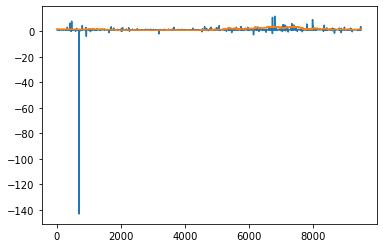

In [127]:
plt.plot(yhat.detach().numpy())
plt.plot(y_train.detach().numpy())

In [128]:
yhat = []
for j in range(100):
    yhat.append(BNNmodel(x_train).detach().numpy())

In [129]:
mu = np.mean(yhat,axis = 0)
std = np.std(yhat,axis = 0)

In [130]:
sum((mu-y_train.detach().numpy())**2)

80727200.0

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.singular_values_

In [ ]:
LOSS = []
BNNmodel = BayesianMLP(10, 1)
epochs = 5000
l = 0.5
train_model(epochs,l)

BNNmodel.eval()


yhat = []
for j in range(100):
    yhat.append(BNNmodel(x_train).detach().numpy())

mu = np.mean(yhat,axis = 0)
std = np.std(yhat,axis = 0)

sum((mu-y_train.detach().numpy())**2)